# Fakenews detection - validation
Tymoteusz Kwieciński, Aleks Kapich

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from wordcloud import WordCloud
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
test=pd.read_csv('testing_data.csv', header=0, sep=',')
train=pd.read_csv('training_data.csv', header=0, sep=',')
val=pd.read_csv('fakenws_validation.csv', header=0, sep=',')

## Train test split
zostało od razu zrobione - przetestujemy czy jest okej

<AxesSubplot:>

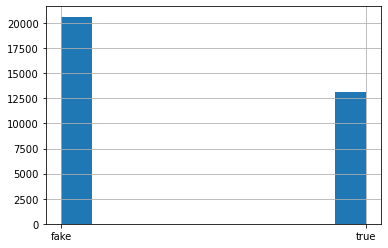

In [5]:
train["label"].hist()

<AxesSubplot:>

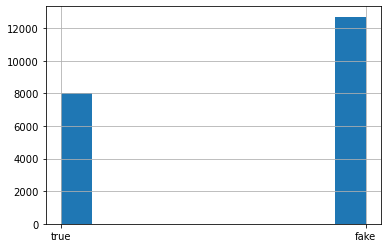

In [6]:
test["label"].hist()

<AxesSubplot:>

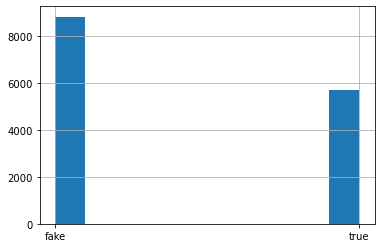

In [7]:
val["label"].hist()

stosunek ilości fake do true wszędzie jest taki sam, więc możemy przyjąć że jest to dobre rozdzielenie danych

In [8]:
train_df = train.copy()

In [9]:
testing_df = test.copy()

In [10]:
# zapisanie ramki do walidacji
validate_df = val.copy()

In [15]:
df2 = testing_df # to nie wiem po co ale pewnie pomoze nam przeklikiwac plik

## Getting to know the data

In [16]:
df2.head()

,title,text,label
0,"As Johnson Sirleaf exits, Liberians thankful f...",MONROVIA (Reuters) - After a dozen years of re...,true
1,French foreign minister says accepting refugee...,PARIS (Reuters) - Consideration for the plight...,true
2,‘We Caved’,"On a late July day this past summer, a roar fi...",true
3,Obama Signs Executive Order Declaring Investig...,64 SHARE President Obama has signed an Executi...,fake
4,"After Florida shooting, Trump hardens stance o...","MANCHESTER, N.H./WASHINGTON (Reuters) - Republ...",true


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20714 entries, 0 to 20713
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20500 non-null  object
 1   text    20692 non-null  object
 2   label   20714 non-null  object
dtypes: object(3)
memory usage: 485.6+ KB


zmienne tekstowe, całkiem sporo, ogólnie wygląda na dosyc mało braków danych, 2 kolumny z tekstem i jedna z targetem - w targecie nie ma braków



## Data Preprocessing

### Encoding

In [18]:
# zamina fake i true na wartości numeryczne
df2.loc[df2["label"] == "fake","label"] = 0
df2.loc[df2["label"] == "true","label"] = 1

In [19]:
# before pipeline function
def encodeLabels(df):
    df.loc[df["label"] == "fake","label"] = 0
    df.loc[df["label"] == "true","label"] = 1
    return df

### NaNs

In [20]:
# Jest bardzo mało nulli więc możemy się ich pozbyć - to nie jest chyba najlepsze rozwiązanie - tutaj mozemy tracic troche informacji jezeli np obecny jest tylko tytuł
# to zdecydowanie do poprawy. Dodatkowo zmniejsza nam sie liczba obserwacji, nieznacząco ale minus
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20478 entries, 0 to 20713
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20478 non-null  object
 1   text    20478 non-null  object
 2   label   20478 non-null  object
dtypes: object(3)
memory usage: 639.9+ KB


In [21]:
# transformer function
def handleNa(df):
    df.dropna(inplace=True)
    print('NaNs deleted')
    return df

### Combine columns

Z racji, że będziemy analizować same słowa, łączymy kolumny title i tekst - dla naszego modelu nie będzie miało znaczenia z której kolumny pochodzą

tutaj rozsądne raczej podejście

In [22]:
df2.loc[8102]

title     Overnight Las Vegas Attack Is Deadliest Mass ...
text     Sunday night at the Route 91 Harvest Festival ...
label                                                    0
Name: 8102, dtype: object

In [23]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [24]:
df2.loc[8102]['text']

" Overnight Las Vegas Attack Is Deadliest Mass Shooting In American History (DETAILS) Sunday night at the Route 91 Harvest Festival 2017, two unknown shooters began gunning down police officers and at least one bodyguard from what appeared to be the 32nd floor of the Mandalay Bay Hotel in Las Vegas.The country music festival was just concluding for the weekend, with the last performer, Jason Aldean, wrapping up his performance for a sold-out crowd of 12,000 people.Twitter was the first place information began to emerge on the shooters and what was happening: pic.twitter.com/4ZhhGiqeDL  kenny terhune jr (@kenny_terhune) October 2, 2017My sister in law just texted me this. They are staying at the Mandalay Bay hotel in Vegas where there was just an active shooter. pic.twitter.com/ldkWUo1NdJ  Brittany Michelle (@britmgarcia) October 2, 2017Per police scanner: Multiple casualties, officer shot in neck possibly another officer dead. #MandalayBay  jordan ghoul ? ? (@JordanUhl) October 2, 2017

In [25]:
df2 = df2.drop(columns='title')

In [26]:
df2.head()

,text,label
0,"As Johnson Sirleaf exits, Liberians thankful f...",1
1,French foreign minister says accepting refugee...,1
2,‘We Caved’ On a late July day this past summer...,1
3,Obama Signs Executive Order Declaring Investig...,0
4,"After Florida shooting, Trump hardens stance o...",1


In [27]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('Columns combined')
    return df

### Outliers

(array([2.0177e+04, 2.5000e+02, 3.6000e+01, 9.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([2.200000e+01, 1.350640e+04, 2.699080e+04, 4.047520e+04,
        5.395960e+04, 6.744400e+04, 8.092840e+04, 9.441280e+04,
        1.078972e+05, 1.213816e+05, 1.348660e+05]),
 <BarContainer object of 10 artists>)

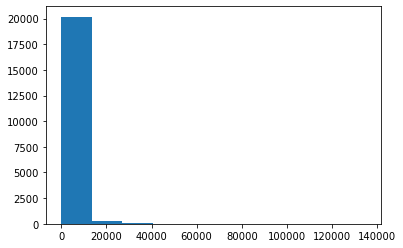

In [28]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [26]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

text          32
label         32
textlength    32
dtype: int64


,text,label,textlength
12641,Re: Why Are So Many People Choosing To Leave T...,0,115924
63859,Re: Why Is Obama Threatening Russia With World...,0,97429
21862,Benny Morris’s Untenable Denial of the Ethnic ...,0,92823
58778,President-Elect Donald Trump's First Televised...,0,41697
18039,Re: The Velocity Of Money In The U.S. Falls To...,0,43623


In [27]:
# Wyrzucamy bardzo dlugie teksty (ponad 40000 znaków)
df2 = df2[(df2['textlength'] < 40000)]
df2.drop(columns='textlength')

,text,label
17623,In the Western World Respect for Law No Longer...,0
61073,"WATCH: President Obama Unleashes On Trump, Sa...",0
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,0
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,0
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,0
...,...,...
59264,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,0
57858,Russia denies its planes killed civilians in S...,1
63057,Hungary’s “Wall” Versus the U.S. “Wall” Op-Ed ...,0
61429,Pastor Caught Trump’s Spiritual Advisor Steal...,0


nie jestem pewien czy to jest niezbedne podejscie - ten rozklad po dodaniu binsów wyglada raczej okej

(array([2.935e+03, 2.427e+03, 3.128e+03, 3.856e+03, 2.326e+03, 1.490e+03,
        1.061e+03, 7.940e+02, 5.710e+02, 3.900e+02, 2.700e+02, 2.330e+02,
        1.610e+02, 1.480e+02, 1.160e+02, 7.200e+01, 6.300e+01, 5.200e+01,
        5.400e+01, 3.000e+01, 2.000e+01, 2.900e+01, 3.200e+01, 2.200e+01,
        1.200e+01, 2.000e+01, 1.300e+01, 1.400e+01, 1.100e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 1.100e+01, 4.000e+00, 3.000e+00, 7.000e+00,
        4.000e+00, 1.500e+01, 4.000e+00, 3.000e+00, 8.000e+00, 7.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

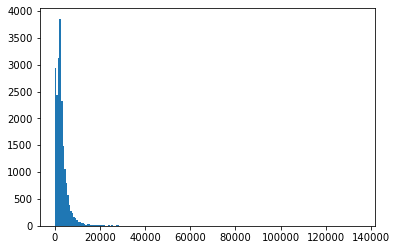

In [30]:
plt.hist(df2['textlength'], bins=200)

brakow tego typu jest na tyle mało ze jest to git

In [77]:
#transformer function
def removeOutliers(df):
    df['textlength'] = df['text'].apply(len)
    df = df[df['textlength'] < 40000]
    df = df.drop(columns='textlength')
    print('Outliers removed')
    return df

### Removing stopwords

In [31]:
#stopword removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [32]:
#punctuation and number removal
def remove_punctuations(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s

In [33]:
df2['text'] = df2['text'].apply(remove_punctuations)
df2['text'] = df2['text'].apply(word_tokenize)

In [34]:
df2['text'] = df2['text'].apply(remove_stopwords)

In [35]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [36]:
df3 = df2.copy()

In [37]:
df3["text"] = df3["text"].apply(list2string)
df3.head()

,text,label,textlength
0,johnson sirleaf exit liberian thankful peace e...,1,4804
1,french foreign minister say accepting refugee ...,1,1425
2,caved late july day past summer roar filled sk...,1,6858
3,obama sign executive order declaring investiga...,0,5422
4,florida shooting trump hardens stance muslim m...,1,4990


In [38]:
# transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(remove_punctuations)
    print('Punctuation removed')
    df['text'] = df['text'].apply(word_tokenize)
    print('Words tokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('Stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

git

### Extracting english

In [39]:
def deleteUrl(text):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

nie jestem pewien czy usunięcie linków jest na pewno dobrym podejsciem - one również mogą nieść jakąś informację - ale ogólnie jest w porządku

In [40]:
# usuwamy linki
df3['text'] = df3['text'].apply(deleteUrl)

In [41]:
# tworzymy krótszą kolumnę do analizy języka
def shortenText(text):
    return text[:60]

In [42]:
df3['shorttext'] = df3['text'].apply(shortenText)

In [43]:
df3[df3['shorttext'].apply(len) < 10]

,text,label,textlength,shorttext
1679,,0,2829,
2440,,0,1318,
2843,,0,1702,
4271,,0,1544,
4454,pravdaru,0,2780,pravdaru
5735,rt,0,1158,rt
6282,wallmart,0,1834,wallmart
6587,,0,6525,
6977,,0,1814,
7582,,0,2548,


In [44]:
# usuwamy teksty które mają mniej niż 10 znaków - były to same linki
df3 = df3[df3['shorttext'].apply(len) > 10]

In [45]:
df3.head()

,text,label,textlength,shorttext
0,johnson sirleaf exit liberian thankful peace e...,1,4804,johnson sirleaf exit liberian thankful peace e...
1,french foreign minister say accepting refugee ...,1,1425,french foreign minister say accepting refugee ...
2,caved late july day past summer roar filled sk...,1,6858,caved late july day past summer roar filled sk...
3,obama sign executive order declaring investiga...,0,5422,obama sign executive order declaring investiga...
4,florida shooting trump hardens stance muslim m...,1,4990,florida shooting trump hardens stance muslim m...


to podejscie do tworzenia kolejnych kopii dataframów jest ogólnie nienajlepsze - wymaga dosyc sporo pamieci

o ile pozwala na "powroty w kodzie" to mi się osobiście srednio podoba, chociaz pewnie jest wygodne

In [46]:
df4 = df3.copy()

In [47]:
DetectorFactory.seed = 0
df4['lang'] = df4['shorttext'].apply(detect)

In [48]:
# robimy model który będzie wykrywał po angielsku
df4 = df4[df4['lang']=='en']

In [49]:
df4 = df4[['text', 'label']].reset_index(drop=True)
df4

,text,label
0,johnson sirleaf exit liberian thankful peace e...,1
1,french foreign minister say accepting refugee ...,1
2,caved late july day past summer roar filled sk...,1
3,obama sign executive order declaring investiga...,0
4,florida shooting trump hardens stance muslim m...,1
...,...,...
17739,polish president back judicial reform spat war...,1
17740,ucla player hold press conferencefinally thank...,0
17741,trump son clarifies gas chamber comment critic...,1
17742,world leader congratulate trump putin anxious ...,0


In [50]:
#transformer function
def dropLanguages(df):
    DetectorFactory.seed = 0
    df['text'] = df['text'].apply(deleteUrl)
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 10]
    print('Text cleaned')
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('Languages dropped')
    return df

In [51]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

### Word Cloud

In [52]:
df_fake = df4[df4["label"] == 0]
df_true = df4[df4["label"] == 1]

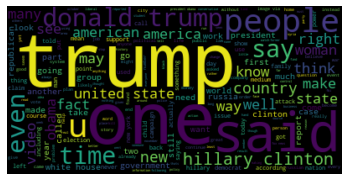

In [53]:
# Fałszywe
consolidated_f = ' '.join(
    word for word in df_fake['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_f)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

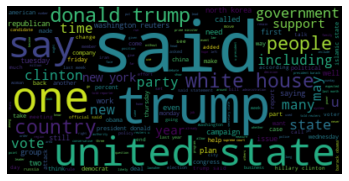

In [54]:
# Prawdziwe
consolidated_t = ' '.join(
    word for word in df_true['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_t)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [2]:
#df4 = pd.read_csv('train_data.csv')

In [55]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df4['text'])

In [56]:
#Transformer function
def myCountVectorizer(df):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df['text'])

In [57]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [58]:
X_train_tfidf.shape

(17744, 136493)

## Pipeline

In [59]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(removeOutliers)
stopwords_transformer = FunctionTransformer(removeStopwords)
language_transformer = FunctionTransformer(dropLanguages)

custom_pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ("stopwords", stopwords_transformer),
    ("language", language_transformer),
])

model_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

NameError: name 'removeOutliers' is not defined

In [110]:
train = pd.read_csv('training_data.csv', index_col=False)

In [111]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [112]:
train = encodeLabels(train)

In [115]:
train_transformed = custom_pipe.transform(train)

NaNs deleted
Columns combined
Outliers removed
Punct removed
Words tokenized
Stopwords removed
Text cleaned
Languages dropped


C:\Users\tymek\AppData\Local\Temp\ipykernel_2952\2669187233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['shorttext'].apply(detect)


In [116]:
train_transformed

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
5,trump crisis lewd remark woman come light new ...,1
...,...,...
33825,trump give brutal warning lawless sanctuary ci...,0
33826,state attorney lied baltimore police probable ...,0
33828,hungary wall versus u wall oped catherine j fr...,0
33829,pastor caught trump spiritual advisor stealing...,0


In [117]:
train_transformed_x = train_transformed['text']
train_transformed_y = train_transformed['label']

In [118]:
train_xx = model_pipe.fit_transform(train_transformed_x, train_transformed_y)

In [119]:
train_xx.shape

(29070, 178186)